# Inicialização

In [1]:
import shapely
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gtfs_kit as gk
import pandas as pd
import swifter
import seaborn as sns

In [3]:
from pathlib import Path

path = Path("./gtfs_rio-de-janeiro.zip")

feed = gk.read_feed(path, dist_units='km')

feed.validate()

,type,message,table,rows
3,error,Invalid route_type; maybe has extra space char...,routes,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
0,warning,Unrecognized column agency_id,fare_attributes,[]
1,warning,Unrecognized column agency_id,fare_rules,[]
2,warning,Unrecognized column feed_contact_email,feed_info,[]
4,warning,Unrecognized column platform_code,stops,[]


# Parâmetros

In [4]:
route = '309'
position_parquet_file = './309_2023.parquet'
trip_parque_file = './309_2023_viagens.parquet'

# Preparação de dados da rota

In [5]:
route_id = feed.routes[feed.routes['route_short_name'] == route]['route_id'].iloc[0]
route_id

'O0309AAA0A'

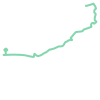

In [6]:
from shapely import LineString, Point

route_geometries = feed.geometrize_routes([route_id], split_directions=True)['geometry']
forwards_geometry: LineString = route_geometries[0]
backwards_geometry: LineString = route_geometries[1]

forwards_geometry

In [7]:
forward_trip = feed.trips[(feed.trips['route_id'] == route_id) & (feed.trips['direction_id'] == 0)].iloc[0]['trip_id']
reverse_trip = feed.trips[(feed.trips['route_id'] == route_id) & (feed.trips['direction_id'] == 1)].iloc[0]['trip_id']
forward_trip, reverse_trip

('8aedc2fc-2ed9-4399-a60d-54501838a81e',
 '8ed81257-ede9-4520-92c8-9d4e77ec6bc6')

In [8]:
forward_trip_stops = feed.stop_times[feed.stop_times['trip_id'] == forward_trip]
backward_trip_stops = feed.stop_times[feed.stop_times['trip_id'] == reverse_trip]

forward_trip_stops['sentido'] = 'I'
backward_trip_stops['sentido'] = 'V'

backward_trip_stops.shape_dist_traveled += forward_trip_stops.shape_dist_traveled.iloc[-1]
backward_trip_stops.stop_sequence += forward_trip_stops.stop_sequence.iloc[-1]

stop_list = pd.concat([forward_trip_stops, backward_trip_stops.iloc[1:]])[['stop_id', 'shape_dist_traveled', 'stop_sequence', 'sentido']]
stop_list['relative_position'] = stop_list['shape_dist_traveled'] / stop_list['shape_dist_traveled'].iloc[-1]
stop_list

C:\Users\thlam\AppData\Local\Temp\ipykernel_9472\449222496.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_trip_stops['sentido'] = 'I'
C:\Users\thlam\AppData\Local\Temp\ipykernel_9472\449222496.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backward_trip_stops['sentido'] = 'V'
C:\Users\thlam\AppData\Local\Temp\ipykernel_9472\449222496.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,stop_id,shape_dist_traveled,stop_sequence,sentido,relative_position
622952,wcdt,0.00,0,I,0.000000
622953,4128O00209C0,2935.40,1,I,0.040796
622954,4128O00035C0,3746.88,2,I,0.052074
622955,4128O00036C0,4178.28,3,I,0.058069
622956,4128O00037C0,4710.90,4,I,0.065471
...,...,...,...,...,...
642557,4128O00121C0,68369.50,137,V,0.950191
642558,4128O00122C0,68793.55,138,V,0.956084
642559,4128O00055C0,69229.90,139,V,0.962148
642560,4128O00056C0,69683.61,140,V,0.968454


In [9]:
stop_geometries = feed.geometrize_stops(stop_list['stop_id'])[['stop_id', 'geometry']]

stop_list = pd.merge(stop_list, stop_geometries, on='stop_id')
stop_list.set_index('stop_sequence', inplace=True)
stop_list.sort_values('relative_position', inplace=True)
stop_list

,stop_id,shape_dist_traveled,sentido,relative_position,geometry
stop_sequence,,,,,
0,wcdt,0.00,I,0.000000,POINT (-43.36520 -23.00147)
1,4128O00209C0,2935.40,I,0.040796,POINT (-43.36633 -23.00904)
2,4128O00035C0,3746.88,I,0.052074,POINT (-43.36793 -23.01099)
3,4128O00036C0,4178.28,I,0.058069,POINT (-43.36461 -23.01085)
4,4128O00037C0,4710.90,I,0.065471,POINT (-43.35939 -23.01065)
...,...,...,...,...,...
137,4128O00121C0,68369.50,V,0.950191,POINT (-43.35994 -23.01039)
138,4128O00122C0,68793.55,V,0.956084,POINT (-43.36371 -23.01049)
139,4128O00055C0,69229.90,V,0.962148,POINT (-43.36601 -23.00861)


# Preparação de dados de ônibus

In [10]:
bus_positions = pd.read_parquet(position_parquet_file)
bus_positions.timestamp_gps = pd.to_datetime(bus_positions.timestamp_gps)
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo
0,2023-09-11 21:38:09,-22.99241,-43.25229,0,27.9,A41163
1,2023-09-11 10:42:11,-22.90465,-43.19259,0,2.8,A41248
2,2023-07-31 09:08:46,-22.99254,-43.25152,0,35.9,A41053
3,2023-07-31 09:37:16,-22.95230,-43.18678,0,13.0,A41053
4,2023-07-31 16:59:46,-22.96065,-43.20704,0,9.6,A41053
...,...,...,...,...,...,...
34383788,2023-02-15 07:29:55,-23.00712,-43.31080,0,18.1,C41430
34383789,2023-02-18 02:57:56,-23.01053,-43.36566,32,19.1,C41430
34383790,2023-04-06 08:17:58,-23.00730,-43.30674,53,18.1,C41430
34383791,2023-04-13 12:04:14,-23.00146,-43.36593,16,12.6,C41430


In [11]:
bus_positions.sort_values('timestamp_gps', inplace=True)
bus_positions.reset_index(drop=True, inplace=True)
bus_positions.drop_duplicates(subset=['id_veiculo', 'timestamp_gps'], inplace=True, keep='last')
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo
0,2023-01-01 00:00:01,-22.87554,-43.24146,0,0.2,C41424
1,2023-01-01 00:00:14,-22.94561,-43.18253,0,29.5,C41265
2,2023-01-01 00:00:26,-23.00025,-43.35741,50,15.9,A41104
3,2023-01-01 00:00:26,-22.87532,-43.24192,0,0.0,A41278
4,2023-01-01 00:00:31,-22.87554,-43.24146,0,0.2,C41424
...,...,...,...,...,...,...
34383788,2023-11-01 23:59:55,-22.90461,-43.19255,0,20.5,C41021
34383789,2023-11-01 23:59:56,-22.90462,-43.19244,0,14.5,A41016
34383790,2023-11-01 23:59:58,-22.90553,-43.18277,26,14.1,A41190
34383791,2023-11-01 23:59:59,-22.99909,-43.24826,43,34.0,A41463


In [1]:
bus_trips = pd.read_parquet(trip_parque_file)
bus_trips.datetime_chegada = pd.to_datetime(bus_trips.datetime_chegada)
bus_trips.datetime_partida = pd.to_datetime(bus_trips.datetime_partida)
bus_trips.sort_values(by='datetime_partida', inplace=True)
bus_trips.reset_index(inplace=True, names='trip_id')
bus_trips

NameError: name 'pd' is not defined

In [13]:
merged_df = pd.merge_asof(bus_positions, bus_trips, by='id_veiculo', left_on='timestamp_gps', right_on='datetime_partida', direction='backward')
merged_df = merged_df[(merged_df['timestamp_gps'] >= merged_df['datetime_partida']) &
                      (merged_df['timestamp_gps'] <= merged_df['datetime_chegada'])]
bus_positions = merged_df.sort_values(['id_veiculo', 'timestamp_gps'])
bus_positions.reset_index(drop=True, inplace=True)
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0


# Cálculo de localização

## Localização relativa do ônibus na rota

In [14]:
def to_point(row):
    return Point(row['longitude'], row['latitude'])
bus_positions['geometry'] = bus_positions[['latitude', 'longitude']].swifter.apply(to_point, axis=1)
bus_positions

Pandas Apply:   0%|          | 0/10306447 [00:00<?, ?it/s]

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116)
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051)
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031)
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179)
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902)
...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116)
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138)
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224)
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033)


In [15]:
total_geometry_length = forwards_geometry.length + backwards_geometry.length

forwards_bus_positions = bus_positions[bus_positions['sentido'] == 'I']
forwards_bus_projections = forwards_geometry.project(forwards_bus_positions['geometry'])
forwards_bus_interpolations = forwards_geometry.interpolate(forwards_bus_projections)
forwards_bus_final_projection = forwards_geometry.project(forwards_bus_interpolations)
forwards_bus_roundtrip_locations = forwards_bus_final_projection / total_geometry_length
forwards_bus_locations = forwards_bus_final_projection / forwards_geometry.length

backwards_bus_positions = bus_positions[bus_positions['sentido'] == 'V']
backwards_bus_projections = backwards_geometry.project(backwards_bus_positions['geometry'])
backwards_bus_interpolations = backwards_geometry.interpolate(backwards_bus_projections)
backwards_bus_final_projection = backwards_geometry.project(backwards_bus_interpolations)
backwards_bus_roundtrip_locations = (backwards_bus_final_projection + forwards_geometry.length) / total_geometry_length
backwards_bus_locations = backwards_bus_final_projection / backwards_geometry.length

bus_positions['relative_roundtrip_distance'] = pd.concat([forwards_bus_roundtrip_locations, backwards_bus_roundtrip_locations])
bus_positions['relative_distance'] = pd.concat([forwards_bus_locations, backwards_bus_locations])
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688


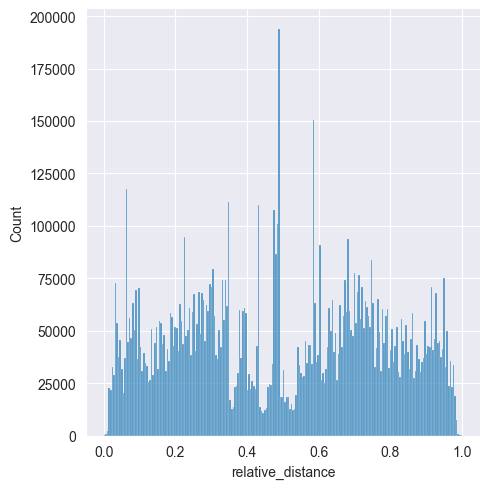

In [16]:
sns.displot(bus_positions['relative_distance'])

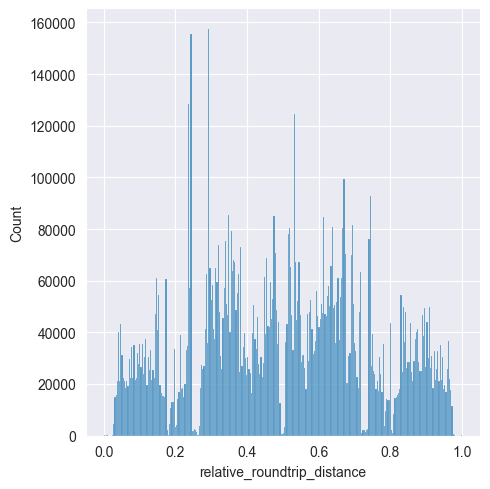

In [17]:
sns.displot(bus_positions['relative_roundtrip_distance'])

## Parada onde o ônibus está

In [18]:
bus_positions['next_stop_index'] = stop_list['relative_position'].searchsorted(bus_positions['relative_roundtrip_distance'], side='left')
bus_positions['previous_stop_index'] = bus_positions['next_stop_index'] - 1
bus_positions.loc[bus_positions['previous_stop_index'] == -1, 'previous_stop_index'] = 0
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67


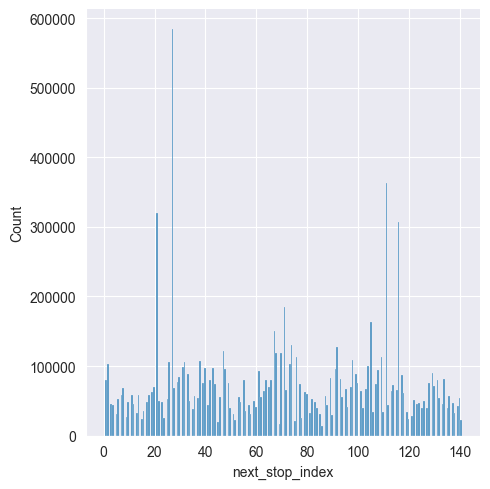

In [19]:
sns.displot(bus_positions['next_stop_index'])

## Distância do ônibus até a rota

In [20]:
forwards_bus_distances = forwards_geometry.distance(forwards_bus_positions['geometry'])
backwards_bus_distances = backwards_geometry.distance(backwards_bus_positions['geometry'])

bus_positions['distance_from_route'] = pd.concat([forwards_bus_distances, backwards_bus_distances])
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index,distance_from_route
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69,0.000042
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69,0.000053
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69,0.000072
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70,0.000014
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66,0.000040
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66,0.000137
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67,0.000101
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67,0.000038


# Análise

## Validade dos dados - os ônibus estão seguindo a rota?

<Axes: ylabel='distance_from_route'>

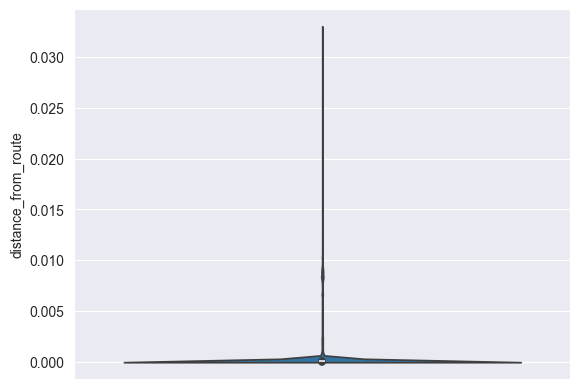

In [21]:
sns.violinplot(bus_positions['distance_from_route'])

## Quais são os piores horários para se pegar essa linha?

In [22]:
hourly_periods = [hour for hour in range(24)]

bus_trips_periods = bus_trips[['datetime_partida', 'datetime_chegada']].swifter.apply(lambda x: [hour for hour in hourly_periods if x['datetime_partida'].hour <= hour <= x['datetime_chegada'].hour], axis=1)
bus_trips_periods

Pandas Apply:   0%|          | 0/63392 [00:00<?, ?it/s]

0             [5]
1          [5, 6]
2          [6, 7]
3          [7, 8]
4          [7, 8]
           ...   
63387    [22, 23]
63388    [22, 23]
63389          []
63390          []
63391          []
Length: 63392, dtype: object

In [23]:
bus_trip_count_by_period = bus_trips_periods.explode().value_counts()

In [24]:
bus_positions['timestamp_hour'] = bus_positions.timestamp_gps.dt.hour

In [25]:
traveling_buses = bus_positions[(bus_positions.next_stop_index != bus_positions.previous_stop_index) & (bus_positions.velocidade_instantanea > 0)]
traveling_buses['stop_distance'] = traveling_buses.swifter.apply(lambda x: stop_list.loc[x['next_stop_index'], 'shape_dist_traveled'] - stop_list.loc[x['previous_stop_index'], 'shape_dist_traveled'], axis=1)
traveling_buses  

Pandas Apply:   0%|          | 0/7140754 [00:00<?, ?it/s]

C:\Users\thlam\AppData\Local\Temp\ipykernel_9472\652173036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traveling_buses['stop_distance'] = traveling_buses.swifter.apply(lambda x: stop_list.loc[x['next_stop_index'], 'shape_dist_traveled'] - stop_list.loc[x['previous_stop_index'], 'shape_dist_traveled'], axis=1)


,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index,distance_from_route,timestamp_hour,stop_distance
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69,0.000042,15,1137.20
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69,0.000053,15,1137.20
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69,0.000072,15,1137.20
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70,0.000014,15,534.65
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70,0.000021,15,534.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66,0.000040,21,487.88
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66,0.000137,21,487.88
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67,0.000101,21,640.61
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67,0.000038,21,640.61


In [26]:
average_speed_by_hour_and_segment = traveling_buses.groupby(['timestamp_hour', 'next_stop_index']).agg({
    'velocidade_instantanea': 'mean',
    'stop_distance': 'first'
}).reset_index()
average_speed_by_hour_and_segment

,timestamp_hour,next_stop_index,velocidade_instantanea,stop_distance
0,0,1,52.889901,2935.40
1,0,2,38.453147,811.48
2,0,3,43.359281,431.40
3,0,4,55.226387,532.62
4,0,5,54.159664,370.84
...,...,...,...,...
3379,23,137,42.392617,455.99
3380,23,138,51.643678,424.05
3381,23,139,48.941532,436.35
3382,23,140,46.512411,453.71


In [27]:
average_speed_by_hour_and_segment['time_to_serve'] = average_speed_by_hour_and_segment['stop_distance'] / (average_speed_by_hour_and_segment['velocidade_instantanea'] / 3.6)
average_speed_by_hour_and_segment

,timestamp_hour,next_stop_index,velocidade_instantanea,stop_distance,time_to_serve
0,0,1,52.889901,2935.40,199.800716
1,0,2,38.453147,811.48,75.971104
2,0,3,43.359281,431.40,35.817937
3,0,4,55.226387,532.62,34.719490
4,0,5,54.159664,370.84,24.649784
...,...,...,...,...,...
3379,23,137,42.392617,455.99,38.722874
3380,23,138,51.643678,424.05,29.559862
3381,23,139,48.941532,436.35,32.096666
3382,23,140,46.512411,453.71,35.116562


In [28]:
stop_serve_time = average_speed_by_hour_and_segment.set_index(["timestamp_hour", "next_stop_index"])['time_to_serve']
stop_serve_time.sort_index(inplace=True)
stop_serve_time

timestamp_hour  next_stop_index
0               1                  199.800716
                2                   75.971104
                3                   35.817937
                4                   34.719490
                5                   24.649784
                                      ...    
23              137                 38.722874
                138                 29.559862
                139                 32.096666
                140                 35.116562
                141                149.979959
Name: time_to_serve, Length: 3384, dtype: float64

In [29]:
from tqdm import tqdm

days = bus_trips.datetime_chegada.dt.day_of_year.unique()

forward_stops = stop_list[stop_list['sentido'] == 'I'].index
backward_stops = stop_list[stop_list['sentido'] == 'V'].index

day_visits = {}
for day in tqdm(days, total=len(days)):
    trips = bus_trips[(bus_trips.datetime_chegada.dt.day_of_year == day)]
    stop_visit_times = {stop: [] for stop in stop_list.index}
    for index, trip in trips.iterrows():
        current_time = trip['datetime_partida']
        
        if trip['sentido'] == 'I':
            stops = forward_stops
        else:
            stops = backward_stops
        
        for stop in stops:
            stop_visit_times[stop].append(current_time)
            
            hour = current_time.hour
            # If this hour and stop are not in the stop_serve_time table, then the bus skips this stop
            if (hour, stop) not in stop_serve_time.index:
                continue
             
            current_time += (stop_serve_time[hour, stop] if stop > 0 else 0) * pd.Timedelta(seconds=1)
    day_visits[day] = stop_visit_times

100%|██████████| 212/212 [02:08<00:00,  1.66it/s]


In [30]:
day_dataframe = pd.DataFrame.from_dict(day_visits, orient='index')
day_dataframe.reset_index(inplace=True, names='day_of_year')
day_dataframe = day_dataframe.melt(
    id_vars=['day_of_year'],
    var_name='stop number',
    value_name='visit_times'
)
day_dataframe = day_dataframe.explode('visit_times', ignore_index=True)
day_dataframe = pd.merge(day_dataframe, stop_list['sentido'], left_on='stop number', right_index=True, how='left')
day_dataframe.sort_values(['day_of_year', 'stop number', 'visit_times'], inplace=True)
day_dataframe

,day_of_year,stop number,visit_times,sentido
0,1,0,2023-01-01 05:00:22.000000000,I
1,1,0,2023-01-01 05:42:45.000000000,I
2,1,0,2023-01-01 06:46:39.000000000,I
3,1,0,2023-01-01 07:04:50.000000000,I
4,1,0,2023-01-01 07:21:04.000000000,I
...,...,...,...,...
4374491,212,137,2023-07-31 00:36:46.840299586,V
4406000,212,138,2023-07-31 00:37:17.025044463,V
4437509,212,139,2023-07-31 00:37:44.447964289,V
4469018,212,140,2023-07-31 00:38:15.009229395,V


In [31]:
day_dataframe = day_dataframe[(7 <= day_dataframe['visit_times'].dt.hour) & (day_dataframe['visit_times'].dt.hour <= 21)]

In [32]:
shifted = day_dataframe.groupby(['day_of_year', 'sentido', 'stop number'])['visit_times'].shift(1)
day_dataframe['time_since_last_visit'] = day_dataframe['visit_times'] - shifted
day_dataframe

C:\Users\thlam\AppData\Local\Temp\ipykernel_9472\1050141554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['time_since_last_visit'] = day_dataframe['visit_times'] - shifted


,day_of_year,stop number,visit_times,sentido,time_since_last_visit
3,1,0,2023-01-01 07:04:50.000000000,I,NaT
4,1,0,2023-01-01 07:21:04.000000000,I,0 days 00:16:14
5,1,0,2023-01-01 08:02:25.000000000,I,0 days 00:41:21
6,1,0,2023-01-01 09:05:06.000000000,I,0 days 01:02:41
7,1,0,2023-01-01 09:11:43.000000000,I,0 days 00:06:37
...,...,...,...,...,...
4500519,211,141,2023-07-30 20:25:44.956084856,V,0 days 00:13:44.267257582
4500520,211,141,2023-07-30 20:37:45.549811711,V,0 days 00:12:00.593726855
4500521,211,141,2023-07-30 20:49:59.254348975,V,0 days 00:12:13.704537264
4500522,211,141,2023-07-30 20:59:43.319961983,V,0 days 00:09:44.065613008


In [33]:
day_dataframe['wait time (s)'] = day_dataframe['time_since_last_visit'].dt.seconds
day_dataframe['wait difference from avg (s)'] = day_dataframe['wait time (s)'] - day_dataframe['wait time (s)'].mean()
day_dataframe

C:\Users\thlam\AppData\Local\Temp\ipykernel_9472\4216892198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['wait time (s)'] = day_dataframe['time_since_last_visit'].dt.seconds
C:\Users\thlam\AppData\Local\Temp\ipykernel_9472\4216892198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['wait difference from avg (s)'] = day_dataframe['wait time (s)'] - day_dataframe['wait time (s)'].mean()


,day_of_year,stop number,visit_times,sentido,time_since_last_visit,wait time (s),wait difference from avg (s)
3,1,0,2023-01-01 07:04:50.000000000,I,NaT,NaN,NaN
4,1,0,2023-01-01 07:21:04.000000000,I,0 days 00:16:14,974.0,503.768108
5,1,0,2023-01-01 08:02:25.000000000,I,0 days 00:41:21,2481.0,2010.768108
6,1,0,2023-01-01 09:05:06.000000000,I,0 days 01:02:41,3761.0,3290.768108
7,1,0,2023-01-01 09:11:43.000000000,I,0 days 00:06:37,397.0,-73.231892
...,...,...,...,...,...,...,...
4500519,211,141,2023-07-30 20:25:44.956084856,V,0 days 00:13:44.267257582,824.0,353.768108
4500520,211,141,2023-07-30 20:37:45.549811711,V,0 days 00:12:00.593726855,720.0,249.768108
4500521,211,141,2023-07-30 20:49:59.254348975,V,0 days 00:12:13.704537264,733.0,262.768108
4500522,211,141,2023-07-30 20:59:43.319961983,V,0 days 00:09:44.065613008,584.0,113.768108


In [34]:
day_dataframe['hour'] = day_dataframe['visit_times'].dt.hour
average_hourly_wait = day_dataframe.groupby(['stop number', 'hour']).agg({
    'wait time (s)': 'mean', 
    'wait difference from avg (s)': 'mean',
    'sentido': 'first'
}).reset_index()
average_hourly_wait

C:\Users\thlam\AppData\Local\Temp\ipykernel_9472\4206033569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['hour'] = day_dataframe['visit_times'].dt.hour


,stop number,hour,wait time (s),wait difference from avg (s),sentido
0,0,7,423.636865,-46.595027,I
1,0,8,404.047824,-66.184068,I
2,0,9,491.268714,21.036822,I
3,0,10,429.396571,-40.835320,I
4,0,11,443.986301,-26.245590,I
...,...,...,...,...,...
2125,141,17,460.754551,-9.477340,V
2126,141,18,493.727090,23.495199,V
2127,141,19,499.437176,29.205285,V
2128,141,20,498.758691,28.526800,V


In [35]:
average_wait_time_by_hour = average_hourly_wait.groupby(['sentido', 'hour']).agg({
    'wait time (s)': 'mean', 
    'wait difference from avg (s)': 'mean'
}).reset_index()
average_wait_time_by_hour

,sentido,hour,wait time (s),wait difference from avg (s)
0,I,7,396.746881,-73.485011
1,I,8,426.366138,-43.865754
2,I,9,440.419017,-29.812875
3,I,10,462.856661,-7.375230
4,I,11,432.687416,-37.544476
5,I,12,473.486118,3.254226
6,I,13,523.495176,53.263284
7,I,14,528.768657,58.536765
8,I,15,534.848470,64.616579
9,I,16,514.228073,43.996181


<Axes: xlabel='hour', ylabel='wait time (s)'>

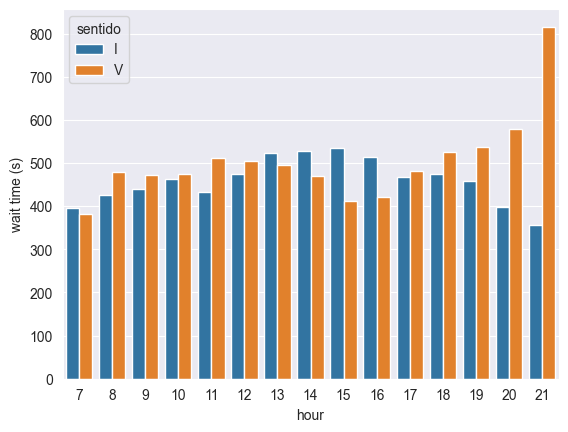

In [36]:
sns.barplot(average_wait_time_by_hour, x='hour', hue='sentido', y='wait time (s)')

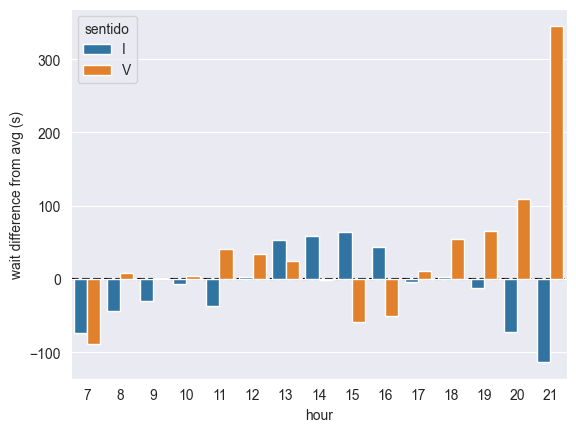

In [37]:
g = sns.barplot(average_wait_time_by_hour, x='hour', hue='sentido', y='wait difference from avg (s)')
line = g.axhline(y=0, color='black', linestyle='--', zorder=-1)

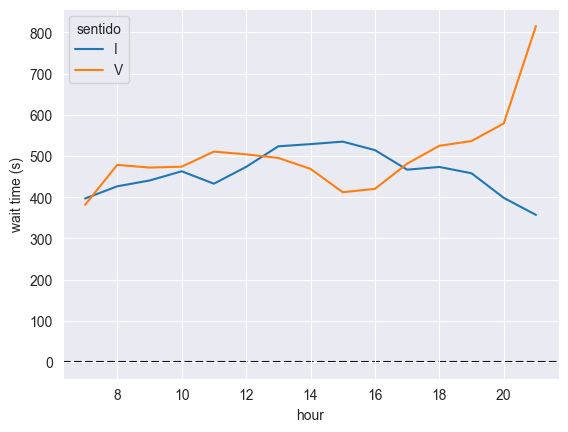

In [38]:
g = sns.lineplot(average_wait_time_by_hour, x='hour', hue='sentido', y='wait time (s)')
line = g.axhline(y=0, color='black', linestyle='--', zorder=-1)

In [39]:
grouped_df = day_dataframe.groupby(['day_of_year', 'sentido', 'hour', 'stop number']).agg({'wait time (s)': 'mean', 'wait difference from avg (s)': 'mean'}).reset_index()

grouped_df

,day_of_year,sentido,hour,stop number,wait time (s),wait difference from avg (s)
0,1,I,7,0,974.0,503.768108
1,1,I,7,1,974.0,503.768108
2,1,I,7,2,974.0,503.768108
3,1,I,7,3,974.0,503.768108
4,1,I,7,4,974.0,503.768108
...,...,...,...,...,...,...
446107,211,V,21,137,1838.5,1368.268108
446108,211,V,21,138,1837.5,1367.268108
446109,211,V,21,139,1836.5,1366.268108
446110,211,V,21,140,2748.0,2277.768108


## Tem motoristas que dirigem significativamente mais rápido que os outros?

In [68]:
bus_positions_normal_hours = bus_positions[(7 <= bus_positions['timestamp_gps'].dt.hour) & (bus_positions['timestamp_gps'].dt.hour <= 21)]
daily_hourly_speed_average = bus_positions_normal_hours.groupby([bus_positions_normal_hours.timestamp_gps.dt.day_of_week, bus_positions_normal_hours.timestamp_gps.dt.hour])['velocidade_instantanea'].agg(velocidade_média_momento='mean')
daily_hourly_speed_average

velocidade_média_momento
timestamp_gps timestamp_gps                          
0             7                             23.428644
              8                             21.618964
              9                             20.917500
              10                            22.163380
              11                            22.224347
...                                               ...
6             17                            22.404065
              18                            22.282446
              19                            24.297047
              20                            26.761779
              21                            28.421003

[105 rows x 1 columns]

In [69]:
trip_average_speed = bus_positions_normal_hours.groupby(['trip_id'])['velocidade_instantanea'].agg(velocidade_média='mean')
trip_average_speed

,velocidade_média
trip_id,
0.0,29.503704
1.0,31.247934
2.0,25.210884
3.0,25.298507
4.0,31.742574
...,...
63387.0,23.403727
63388.0,36.547170
63389.0,24.478261


In [70]:
trips_with_average_speed = pd.merge(bus_trips, trip_average_speed, left_on='trip_id', right_index=True)
trips_with_average_speed

,trip_id,datetime_partida,datetime_chegada,id_veiculo,sentido,tempo_viagem,velocidade_média
2,6324,2023-01-01 06:46:39,2023-01-01 07:57:09,A41282,I,72,26.707965
3,6331,2023-01-01 07:04:50,2023-01-01 08:10:50,C41010,I,67,29.338346
4,6335,2023-01-01 07:21:04,2023-01-01 08:22:34,C41021,I,62,30.685484
5,6354,2023-01-01 08:02:25,2023-01-01 09:06:25,C41372,I,65,29.400000
6,6360,2023-01-01 09:05:06,2023-01-01 10:24:33,C41396,I,80,26.477419
...,...,...,...,...,...,...,...
63379,33879,2023-07-30 20:48:13,2023-07-30 21:58:13,A41464,V,71,27.482270
63380,33832,2023-07-30 21:03:39,2023-07-30 22:08:39,A41296,V,66,26.734513
63381,33839,2023-07-30 21:15:00,2023-07-30 22:25:00,A41370,I,71,29.133333
63382,33855,2023-07-30 21:17:59,2023-07-30 22:23:29,A41453,I,67,31.505882


In [71]:
trips_with_average_speed['datetime_meio'] = trips_with_average_speed['datetime_partida'] + (trips_with_average_speed['datetime_chegada'] - trips_with_average_speed['datetime_partida']) / 2
trips_with_average_speed

,trip_id,datetime_partida,datetime_chegada,id_veiculo,sentido,tempo_viagem,velocidade_média,datetime_meio
2,6324,2023-01-01 06:46:39,2023-01-01 07:57:09,A41282,I,72,26.707965,2023-01-01 07:21:54.000
3,6331,2023-01-01 07:04:50,2023-01-01 08:10:50,C41010,I,67,29.338346,2023-01-01 07:37:50.000
4,6335,2023-01-01 07:21:04,2023-01-01 08:22:34,C41021,I,62,30.685484,2023-01-01 07:51:49.000
5,6354,2023-01-01 08:02:25,2023-01-01 09:06:25,C41372,I,65,29.400000,2023-01-01 08:34:25.000
6,6360,2023-01-01 09:05:06,2023-01-01 10:24:33,C41396,I,80,26.477419,2023-01-01 09:44:49.500
...,...,...,...,...,...,...,...,...
63379,33879,2023-07-30 20:48:13,2023-07-30 21:58:13,A41464,V,71,27.482270,2023-07-30 21:23:13.000
63380,33832,2023-07-30 21:03:39,2023-07-30 22:08:39,A41296,V,66,26.734513,2023-07-30 21:36:09.000
63381,33839,2023-07-30 21:15:00,2023-07-30 22:25:00,A41370,I,71,29.133333,2023-07-30 21:50:00.000
63382,33855,2023-07-30 21:17:59,2023-07-30 22:23:29,A41453,I,67,31.505882,2023-07-30 21:50:44.000


In [72]:
trips_with_average_speed['dia'] = trips_with_average_speed['datetime_meio'].dt.day_of_week
trips_with_average_speed['hora'] = trips_with_average_speed['datetime_meio'].dt.hour
trips_with_average_speed

,trip_id,datetime_partida,datetime_chegada,id_veiculo,sentido,tempo_viagem,velocidade_média,datetime_meio,dia,hora
2,6324,2023-01-01 06:46:39,2023-01-01 07:57:09,A41282,I,72,26.707965,2023-01-01 07:21:54.000,6,7
3,6331,2023-01-01 07:04:50,2023-01-01 08:10:50,C41010,I,67,29.338346,2023-01-01 07:37:50.000,6,7
4,6335,2023-01-01 07:21:04,2023-01-01 08:22:34,C41021,I,62,30.685484,2023-01-01 07:51:49.000,6,7
5,6354,2023-01-01 08:02:25,2023-01-01 09:06:25,C41372,I,65,29.400000,2023-01-01 08:34:25.000,6,8
6,6360,2023-01-01 09:05:06,2023-01-01 10:24:33,C41396,I,80,26.477419,2023-01-01 09:44:49.500,6,9
...,...,...,...,...,...,...,...,...,...,...
63379,33879,2023-07-30 20:48:13,2023-07-30 21:58:13,A41464,V,71,27.482270,2023-07-30 21:23:13.000,6,21
63380,33832,2023-07-30 21:03:39,2023-07-30 22:08:39,A41296,V,66,26.734513,2023-07-30 21:36:09.000,6,21
63381,33839,2023-07-30 21:15:00,2023-07-30 22:25:00,A41370,I,71,29.133333,2023-07-30 21:50:00.000,6,21
63382,33855,2023-07-30 21:17:59,2023-07-30 22:23:29,A41453,I,67,31.505882,2023-07-30 21:50:44.000,6,21


In [73]:
trip_speed_comparison = pd.merge(trips_with_average_speed, daily_hourly_speed_average, left_on=['dia', 'hora'], right_index=True)[['trip_id', 'velocidade_média', 'velocidade_média_momento']]
trip_speed_comparison

,trip_id,velocidade_média,velocidade_média_momento
2,6324,26.707965,29.21922
3,6331,29.338346,29.21922
4,6335,30.685484,29.21922
1783,8964,24.171429,29.21922
1784,9069,40.652174,29.21922
...,...,...,...
63198,55656,28.832061,26.16226
63199,55670,27.384000,26.16226
63200,55497,27.358974,26.16226
63201,55610,28.271739,26.16226


In [74]:
trip_speed_comparison['diferença de velocidade'] = trip_speed_comparison['velocidade_média'] - trip_speed_comparison['velocidade_média_momento']
trip_speed_comparison

,trip_id,velocidade_média,velocidade_média_momento,diferença de velocidade
2,6324,26.707965,29.21922,-2.511256
3,6331,29.338346,29.21922,0.119126
4,6335,30.685484,29.21922,1.466264
1783,8964,24.171429,29.21922,-5.047792
1784,9069,40.652174,29.21922,11.432954
...,...,...,...,...
63198,55656,28.832061,26.16226,2.669801
63199,55670,27.384000,26.16226,1.221740
63200,55497,27.358974,26.16226,1.196714
63201,55610,28.271739,26.16226,2.109479


<Axes: xlabel='diferença de velocidade', ylabel='Density'>

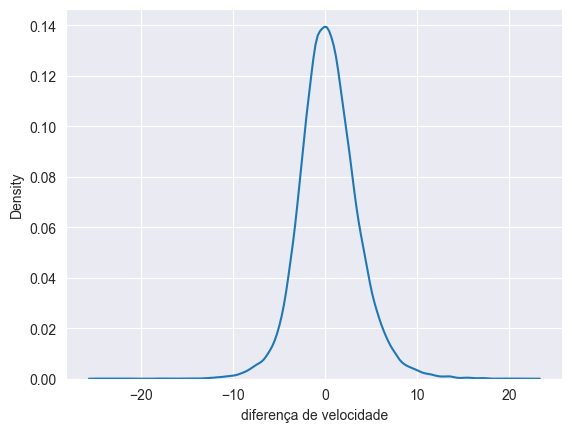

In [78]:
sns.kdeplot(trip_speed_comparison['diferença de velocidade'])

<Axes: ylabel='diferença de velocidade'>

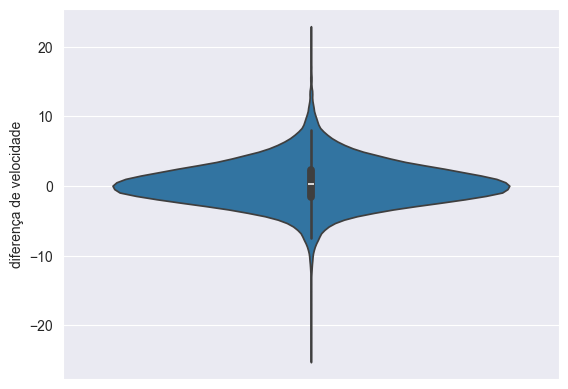

In [76]:
sns.violinplot(trip_speed_comparison['diferença de velocidade'])

In [77]:
trip_speed_comparison['diferença de velocidade'].describe()

count    48308.000000
mean         0.380130
std          3.246089
min        -24.557096
25%         -1.624808
50%          0.225376
75%          2.243619
max         22.173367
Name: diferença de velocidade, dtype: float64